# L06: IIoT Time Series Forecasting Lab

### 1. Installing/Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nixtla import NixtlaClient  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from src.model_training import train_and_predict
from src.evaluation import evaluate_model
import logging
from datetime import timedelta
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras import layers, Model


### 2. Data Preparation

In [5]:
df = pd.read_csv('IOT-temp.csv')

In [6]:
df.head()

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In


#### Observation:

The dataset contains 97,606 entries and 5 columns:

id: Unique identifier

room_id/id: Room name/ label (e.g., "Room Admin")

noted_date: A timestamp in the format DD-MM-YYYY HH:MM

temp: Temperature (integer values)

out/in: Whether the temperature was recorded inside ("In") or outside ("Out")

In [8]:
df.columns = df.columns.str.strip()

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97606 entries, 0 to 97605
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          97606 non-null  object
 1   room_id/id  97606 non-null  object
 2   noted_date  97606 non-null  object
 3   temp        97606 non-null  int64 
 4   out/in      97606 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.7+ MB


In [10]:
df.isnull().sum()

id            0
room_id/id    0
noted_date    0
temp          0
out/in        0
dtype: int64

#### Observation:

There are no missing values in any column.

noted_date is a string and will be converted to datetime object.

temp is numeric.

Other fields are categorical

In [12]:
df.describe()

,temp
count,97606.000000
mean,35.053931
std,5.699825
min,21.000000
25%,30.000000
50%,35.000000
75%,40.000000
max,51.000000


#### Observation:

Temperature Data Summary:

Min: 21°C

Max: 51°C

Mean: 35.05°C

Std Dev: ~5.7


#### Checking for Outliers

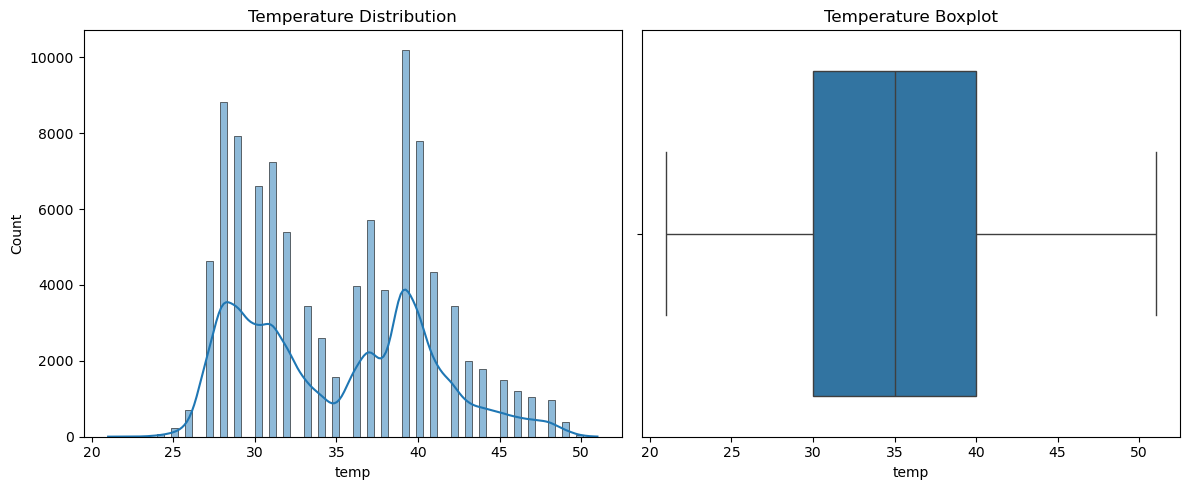

In [15]:
# Check for outliers in temp

# Plot distribution and boxplot of temp
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['temp'], kde=True)
plt.title("Temperature Distribution")

plt.subplot(1, 2, 2)
sns.boxplot(x=df['temp'])
plt.title("Temperature Boxplot")

plt.tight_layout();

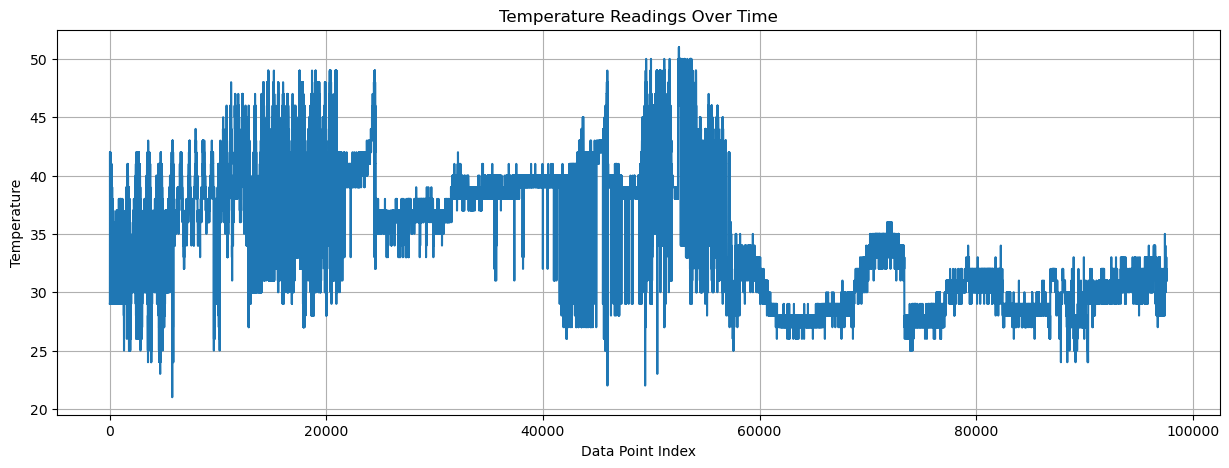

In [16]:
plt.figure(figsize=(15, 5))
df['temp'].plot(title='Temperature Readings Over Time')
plt.ylabel('Temperature')
plt.xlabel('Data Point Index')
plt.grid(True)
plt.show()

#### Observation:

Outlier Thresholds (using IQR):

Q1 = 30, Q3 = 40 → IQR = 10

Lower Bound = 30 - 1.5×10 = 15 → No lower outliers

Upper Bound = 40 + 1.5×10 = 55 → No upper outliers

No significant outliers were detected.

The distribution looks normal, though slightly skewed toward the higher end.


In [18]:
#Rename using lowercase cleaned names
df = df.rename(columns={'noted_date': 'timestamp', 'temp': 'temperature'})


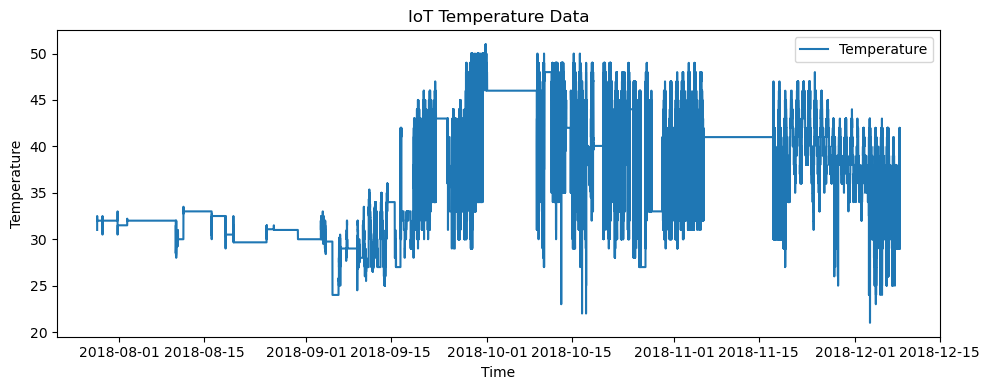

In [19]:
# Convert 'timestamp' column to datetime using dayfirst=True
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Aggregate duplicate timestamps by taking the mean temperature
df = df.groupby('timestamp', as_index=False).agg({'temperature': 'mean'})

# Sort the data by timestamp
df = df.sort_values('timestamp')

# Set timestamp as the index and attempt to infer frequency
df = df.set_index('timestamp')
freq = pd.infer_freq(df.index)
if freq is None:
    # Compute median time difference (in seconds) to choose a frequency
    diffs = df.index.to_series().diff().dropna().dt.total_seconds()
    median_diff = diffs.median()
    if median_diff < 60:
        freq = 'S'  # seconds
    elif median_diff < 3600:
        freq = 'min'  # minutes
    
    elif median_diff < 86400:
        freq = 'H'  # hourly
    else:
        freq = 'D'  # daily

# Resample to a regular frequency using forward fill for missing values
df = df.asfreq(freq, method='ffill').reset_index()

# Plot the temperature data and save the figure
plt.figure(figsize=(10, 4))
plt.plot(df['timestamp'], df['temperature'], label='Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('IoT Temperature Data')
plt.legend()
plt.tight_layout()
plt.show()


### 3. Feature Engineering

In [21]:
# feature_engineering

# Custom Feature 1: Rolling Mean Temperature
df['rolling_mean_temp'] = df['temperature'].rolling(window=5, min_periods=1).mean()
    
# Custom Feature 2: Hour of Day (for capturing diurnal patterns)
df['hour'] = df['timestamp'].dt.hour

  

### 4. Model Training

In [23]:
# model training

# Step 1: Instantiate NixtlaClient with your API Key
nixtla_client = NixtlaClient(api_key='nixak-a6n4A4bdu8dFLshYiJVEocnAauO0cuOg9PJJCcvIhAzYRSPNCthA7GVVkNQylRFy8JdrSMfzySpYkf3a')

# Step 2: Split dataset into train and test (80/20)
train_size = int(0.8 * len(df))
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

# Step 3: Rename training columns to Nixtla format
train_renamed = train.rename(columns={'timestamp': 'ds', 'temperature': 'y'})

# Step 4: Forecast using Nixtla AutoML (with exogenous features)
horizon = len(test)
forecast = nixtla_client.forecast(
    train_renamed,
    h=horizon,
    level=[80, 90],
    hist_exog_list=['rolling_mean_temp', 'hour']
)

# Step 5: Display forecast
print("Forecast:")
print(forecast)


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: min
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['rolling_mean_temp', 'hour']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Forecast:
                       ds    TimeGPT  TimeGPT-hi-80  TimeGPT-hi-90  \
0     2018-11-11 18:38:00  41.000256      41.327400      42.034310   
1     2018-11-11 18:39:00  41.000570      41.624690      42.705616   
2     2018-11-11 18:40:00  41.000830      41.794067      43.309444   
3     2018-11-11 18:41:00  41.001144      41.946724      43.840317   
4     2018-11-11 18:42:00  41.001410      42.083984      44.121223   
...                   ...        ...            ...            ...   
38328 2018-12-08 09:26:00  41.007908      41.335052      42.041960   
38329 2018-12-08 09:27:00  41.007908      41.632030      42.712955   
38330 2018-12-08 09:28:00  41.007908      41.801140      43.316520   
38331 2018-12-08 09:29:00  41.007908      41.953484      43.847080   
38332 2018-12-08 09:30:00  41.007908      42.090485      44.127720   

       TimeGPT-lo-80  TimeGPT-lo-90  
0          40.673110      39.966200  
1          40.376446      39.295520  
2          40.207596      38.692220

### 5. Evaluation

In [25]:
# Evaluation

# Ensure timestamp alignment (optional but good practice)
forecast['ds'] = pd.to_datetime(forecast['ds'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

# Align the test and forecast data
merged = test.merge(forecast[['ds', 'TimeGPT']], left_on='timestamp', right_on='ds', how='inner')

# Extract true and predicted values
true_values = merged['temperature'].values
predicted_values = merged['TimeGPT'].values

# Compute evaluation metrics
mae = mean_absolute_error(true_values, predicted_values)
mse = mean_squared_error(true_values, predicted_values)

# Print results
summary_df = pd.DataFrame({
    "Metric": ["MAE", "MSE"],
    "Value": [mae, mse]
})
summary_df.style.set_caption("Evaluation Metrics")



,Metric,Value
0,MAE,3.296542
1,MSE,23.713734


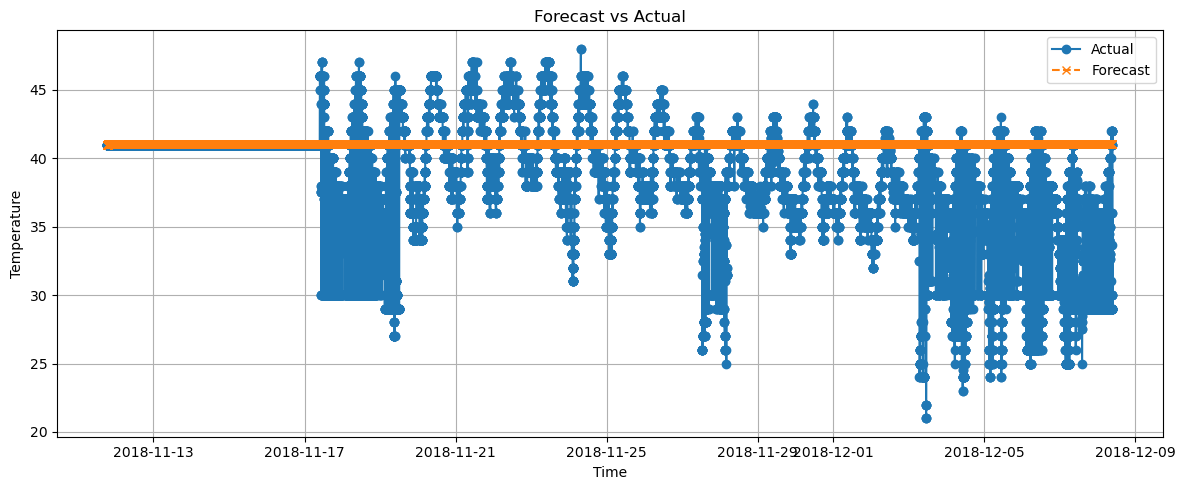

In [26]:
# Forecast vs Actual Plot 

plt.figure(figsize=(12, 5))
plt.plot(merged['timestamp'], merged['temperature'], label='Actual', marker='o')
plt.plot(merged['timestamp'], merged['TimeGPT'], label='Forecast', linestyle='--', marker='x')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [27]:
# cross_validation

# set up logging to see progress
logging.basicConfig(level=logging.INFO)

# Set cross-validation parameters
initial_train_ratio = 0.5
n_splits = 5

# Step 1: Set sizes
n = len(df)
initial_train_size = int(n * initial_train_ratio)
split_size = (n - initial_train_size) // n_splits
metrics_list = []

# Step 2: Perform rolling-origin splits
for i in range(n_splits):
    train_end = initial_train_size + i * split_size
    test_end = train_end + split_size
    if test_end > n:
        test_end = n
    
    train_df = df.iloc[:train_end].copy()
    test_df = df.iloc[train_end:test_end].copy()

    if len(test_df) == 0:
        break

    # Rename training columns
    df_train = train_df.rename(columns={'timestamp': 'ds', 'temperature': 'y'})

    # Forecast using Nixtla
    horizon = len(test_df)
    forecast = nixtla_client.forecast(
        df_train,
        h=horizon,
        level=[80, 90],
        hist_exog_list=['rolling_mean_temp', 'hour']
    )

    # Align timestamps
    forecast['ds'] = pd.to_datetime(forecast['ds'])
    test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

    merged = test_df.merge(forecast[['ds', 'TimeGPT']], left_on='timestamp', right_on='ds', how='inner')
    true_values = merged['temperature'].values
    predicted_values = merged['TimeGPT'].values

    # Calculate metrics
    mae = mean_absolute_error(true_values, predicted_values)
    mse = mean_squared_error(true_values, predicted_values)
    metrics = {'MAE': mae, 'MSE': mse}
    metrics_list.append(metrics)

    logging.info(f"CV Split {i+1}: Train Size = {len(train_df)}, Test Size = {len(test_df)}, Metrics = {metrics}")

# Final output
print("Rolling-Origin CV Metrics:")
for i, m in enumerate(metrics_list, 1):
    print(f"Split {i}: MAE = {m['MAE']:.4f}, MSE = {m['MSE']:.4f}")


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: min
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['rolling_mean_temp', 'hour']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:root:CV Split 1: Train Size = 95832, Test Size = 19166, Metrics = {'MAE': 1.9946789987334368, 'MSE': 16.73179286260092}
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: min
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['rolling_mean_temp', 'hour']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:root:CV Split 2: Train Size = 114998, Test Size = 19166, Metrics = {'MAE': 5.197596956798497, 'MSE': 42.01917615885478}
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: min
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixt

Rolling-Origin CV Metrics:
Split 1: MAE = 1.9947, MSE = 16.7318
Split 2: MAE = 5.1976, MSE = 42.0192
Split 3: MAE = 7.7261, MSE = 70.8891
Split 4: MAE = 2.0224, MSE = 11.4070
Split 5: MAE = 3.6894, MSE = 20.2269


### 6. Generative Modeling

In [29]:
# Generate model

# Prepare sequences
timesteps = 10
features = 1
data = df['temperature'].values
sequences = np.array([data[i:i+timesteps] for i in range(len(data) - timesteps)])
sequences = sequences.reshape(-1, timesteps, features)

# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
latent_dim = 2
encoder_inputs = layers.Input(shape=(timesteps, features))
x = layers.LSTM(64)(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.RepeatVector(timesteps)(latent_inputs)
x = layers.LSTM(64, return_sequences=True)(x)
decoder_outputs = layers.TimeDistributed(layers.Dense(features))(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

# VAE model as a class to handle custom loss
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=[1, 2]))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.loss_tracker.update_state(total_loss)
        return {"loss": self.loss_tracker.result()}

# Instantiate and train
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(sequences, epochs=10, batch_size=32, verbose=1)

# Generate synthetic data
num_samples = len(sequences)
latent_dim = 2
synthetic_latent = np.random.normal(size=(num_samples, latent_dim))
synthetic_sequences = decoder.predict(synthetic_latent)
synthetic_data = synthetic_sequences.reshape(-1)
synthetic_df = pd.DataFrame(synthetic_data, columns=["temperature"])

print(synthetic_df.head())


Epoch 1/10
5990/5990 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 1434.6273
Epoch 2/10
5990/5990 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 27.6103
Epoch 3/10
5990/5990 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 25.4759
Epoch 4/10
5990/5990 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 24.3595
Epoch 5/10
5990/5990 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 23.5270
Epoch 6/10
5990/5990 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 22.5240
Epoch 7/10
5990/5990 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 22.0099
Epoch 8/10
5990/5990 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - loss: 21.8584
Epoch 9/10
5990/5990 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - loss: 21.6976
Epoch 10/10
5990/5990 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 21.4708
5990/5990 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
   temperature
0    33.619137
1    33.407616
2    33.589386
3    33.690704
4    33.710197


In [30]:
# retrain model with synthetic data


# Step 1: Generate synthetic timestamps
last_timestamp = df['timestamp'].max()
synthetic_timestamps = [last_timestamp + timedelta(minutes=i+1) for i in range(len(synthetic_df))]
synthetic_df['timestamp'] = synthetic_timestamps

# Step 2: Add required features to synthetic data
synthetic_df['rolling_mean_temp'] = synthetic_df['temperature']  # simple proxy for rolling mean
synthetic_df['hour'] = [ts.hour for ts in synthetic_df['timestamp']]

# Step 3: Combine original and synthetic data
augmented_df = pd.concat([df, synthetic_df], ignore_index=True).sort_values('timestamp').reset_index(drop=True)

# Step 4: Split into train and test sets
train_size = int(0.8 * len(augmented_df))
train_aug = augmented_df.iloc[:train_size].copy()
test_aug = augmented_df.iloc[train_size:].copy()

# Step 5: Prepare for Nixtla
train_renamed = train_aug.rename(columns={'timestamp': 'ds', 'temperature': 'y'})

# Step 6: Forecast using Nixtla AutoML
horizon = min(100, len(test_aug))  
forecast_aug = nixtla_client.forecast(
    train_renamed,
    h=horizon,
    level=[80, 90],
    hist_exog_list=['rolling_mean_temp', 'hour']
)

# Step 7: Evaluate new model
forecast_aug['ds'] = pd.to_datetime(forecast_aug['ds'])
test_aug['timestamp'] = pd.to_datetime(test_aug['timestamp'])

merged_aug = test_aug.merge(forecast_aug[['ds', 'TimeGPT']], left_on='timestamp', right_on='ds', how='inner')
true_values_aug = merged_aug['temperature'].values
predicted_values_aug = merged_aug['TimeGPT'].values

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_aug = mean_absolute_error(true_values_aug, predicted_values_aug)
mse_aug = mean_squared_error(true_values_aug, predicted_values_aug)

# Step 8: Print Results
print("Evaluation After Re-training with Augmented Data:")
print(f"MAE: {mae_aug:.4f}")
print(f"MSE: {mse_aug:.4f}")


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: min
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['rolling_mean_temp', 'hour']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
ERROR:nixtla.nixtla_client:Attempt 1 failed with error: The read operation timed out


Evaluation After Re-training with Augmented Data:
MAE: 4.9154
MSE: 34.1409


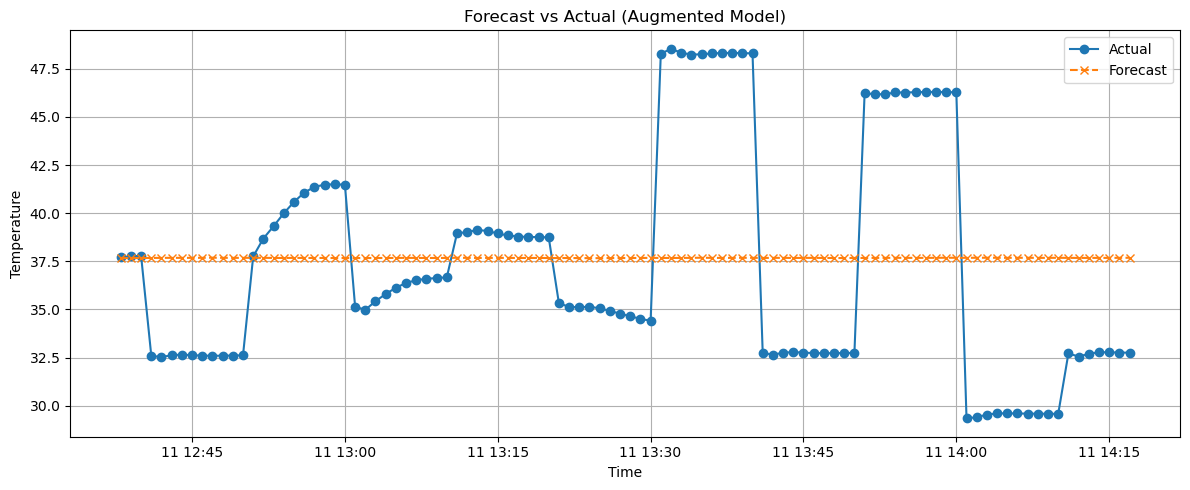

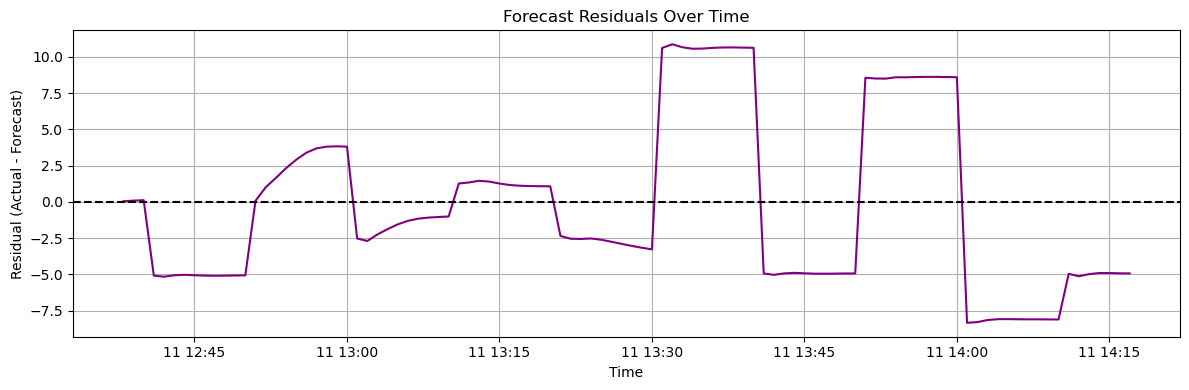

In [31]:
# Visualization: Forecast vs Actual & Residuals After Retraining

# Ensure datetime alignment
forecast_aug['ds'] = pd.to_datetime(forecast_aug['ds'])
test_aug['timestamp'] = pd.to_datetime(test_aug['timestamp'])

# Merge for plotting
merged_aug = test_aug.merge(forecast_aug[['ds', 'TimeGPT']], left_on='timestamp', right_on='ds', how='inner')

# === 1. Forecast vs Actual ===
plt.figure(figsize=(12, 5))
plt.plot(merged_aug['timestamp'], merged_aug['temperature'], label='Actual', marker='o')
plt.plot(merged_aug['timestamp'], merged_aug['TimeGPT'], label='Forecast', linestyle='--', marker='x')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Forecast vs Actual (Augmented Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. Residuals Plot ===
merged_aug['residual'] = merged_aug['temperature'] - merged_aug['TimeGPT']
plt.figure(figsize=(12, 4))
plt.plot(merged_aug['timestamp'], merged_aug['residual'], label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Residual (Actual - Forecast)")
plt.title("Forecast Residuals Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()
